In [1]:
###############################################
# Loading Data with Already Computed Features #
###############################################

# Run this cell to load data and computed features into the data frame df_all_matches

from   IPython.display   import display

import pandas            as     pd
import numpy             as     np
import matplotlib.pyplot as     plt

from   math              import *
from   sklearn.metrics   import mean_squared_error
from   sklearn.metrics   import accuracy_score

df_all_matches = pd.read_csv("data_with_features/1992-2021_mmb_3.csv")

df_all_matches.head()

Season Start Year  Match Day Weekday        Date       Home Team Result  \
0               1992          1     Fri  14.08.1992        Nürnberg    0–0   
1               1992          1     Fri  14.08.1992  Kaiserslautern    1–0   
2               1992          1     Fri  14.08.1992      Leverkusen    1–1   
3               1992          1     Sat  15.08.1992         Schalke    3–4   
4               1992          1     Sat  15.08.1992       Karlsruhe    4–2   

         Away Team  Target  Target HT Win  Target Draw  ...  \
0           Bremen     0.5              0            1  ...   
1             Köln     1.0              1            0  ...   
2      Saarbrücken     0.5              0            1  ...   
3     Wattenscheid     0.0              0            0  ...   
4  Mönchengladbach     1.0              1            0  ...   

   RSBL AT Goals Conceded  DC Have Met 1  DC 1 Goals Shot HT  \
0                      -1              0                  -1   
1                      -1              0                  -1   
2                      -1              0                  -1   
3                      -1              0                  -1   
4                      -1              0                  -1   

   DC 1 Goals Shot AT  DC Have Met 2  DC 2 Goals Shot HT  DC 2 Goals Shot AT  \
0                  -1              0                  -1                  -1   
1                  -1              0                  -1                  -1   
2                  -1              0                  -1                  -1   
3                  -1              0                  -1                  -1   
4                  -1              0                  -1                  -1   

   DC Have Met 3  DC 3 Goals Shot HT  DC 3 Goals Shot AT  
0              0                  -1                  -1  
1              0                  -1                  -1  
2              0                  -1                  -1  
3              0                  -1                  -1  
4              0                  -1                  -1  

[5 rows x 53 columns]

In [3]:
df_all_matches.iloc[0]

Season Start Year                    1992
Match Day                               1
Weekday                               Fri
Date                           14.08.1992
Home Team                        Nürnberg
Result                                0–0
Away Team                          Bremen
Target                                0.5
Target HT Win                           0
Target Draw                             1
Target AT Win                           0
Sufficient History                  False
Cur HT Rank                             1
Cur AT Rank                             1
Cur HT Points                           0
Cur AT Points                           0
Cur HT Goals Shot                       0
Cur AT Goals Shot                       0
Cur HT Goals Conceded                   0
Cur AT Goals Conceded                   0
Participated Last Season HT             0
Participated Last Season AT             0
Fin HT Rank                            -1
Fin AT Rank                       

In [37]:
################################################
# Machine Learning without Additional Features #
################################################

# Run this cell to:
#
# - Define features
# - Split data into training- and validation-data
# - Extract targets
# - Extract features
# - Scale features
#
# To include additional features as well, run the next cell instead.


# Extract data to learn from

df_learning_data = df_all_matches[df_all_matches["Sufficient History"]]
df_learning_data = df_learning_data[  (df_learning_data["Participated Last Season HT"] == 1)
                                    & (df_learning_data["Participated Last Season AT"] == 1)] # To simplify things,
                                                                                              # only games with both
                                                                                              # teams playing in this
                                                                                              # league at least 
                                                                                              # since last season
                                                                                              # are considered.
# Define features

#features = ["Match Day",
#            "Cur HT Rank",                 "Cur AT Rank"]

features = ["Match Day",
            "Cur HT Rank",                 "Cur AT Rank",
            "Cur HT Points",               "Cur AT Points",
            "Cur HT Goals Shot",           "Cur AT Goals Shot",
            "Cur HT Goals Conceded",       "Cur AT Goals Conceded",
            "Participated Last Season HT", "Participated Last Season AT",
            "Fin HT Rank",                 "Fin AT Rank",
            "Fin HT Points",               "Fin AT Points",
            "Fin HT Goals Shot",           "Fin AT Goals Shot",
            "Fin HT Goals Conceded",       "Fin AT Goals Conceded",
            "RSIG Matches Before HT",      "RSIG Matches Before AT",
            "RSIG HT Points",              "RSIG AT Points",
            "RSIG HT Goals Shot",          "RSIG AT Goals Shot",
            "RSIG HT Goals Conceded",      "RSIG AT Goals Conceded",
            "RSBL HT Points",              "RSBL AT Points",
            "RSBL HT Goals Shot",          "RSBL AT Goals Shot",
            "RSBL HT Goals Conceded",      "RSBL AT Goals Conceded",
            "DC Have Met 1",
            "DC 1 Goals Shot HT",          "DC 1 Goals Shot AT",
            "DC Have Met 2",
            "DC 2 Goals Shot HT",          "DC 2 Goals Shot AT",
            "DC Have Met 3",
            "DC 3 Goals Shot HT",          "DC 3 Goals Shot AT"]

# Split data into training- and validation-data

#df_train = df_learning_data.sample(frac = 0.7)
##df_train = df_all_matches.sample(frac = 0.7, random_state = 0)
#df_valid = df_learning_data.drop(df_train.index)

df_train = df_learning_data[df_learning_data["Season Start Year"] <= 2013] # A temporal train-test-split avoids
df_valid = df_learning_data[df_learning_data["Season Start Year"] >= 2014] # train-test-contamination that is
                                                                           # otherwise caused by the nature of the
                                                                           # features. Unfortunately, this prevents
                                                                           # the models from catching patterns that
                                                                           # occur in the later seasons only.
                                                                           # The features also make information leak
                                                                           # from training- to test-data.
percentage_train = 100 * len(df_train) / (len(df_train) + len(df_valid))
percentage_valid = 100 * len(df_valid) / (len(df_train) + len(df_valid))

print("Data is split into %2.1f %% trainig- and %2.1f %% validation-data." % (percentage_train, percentage_valid))

# Extract targets

y_train = df_train["Target HT Win"]
y_valid = df_valid["Target HT Win"]

# Extract features

X_train = df_train[features]
X_valid = df_valid[features]

# Scale features

from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Data is split into 70.4 % trainig- and 29.6 % validation-data.


In [2]:
#############################################
# Machine Learning with Additional Features #
#############################################

# Run this cell to:
#
# - Create additional features
# - Define features
# - Split data into training- and validation-data
# - Extract targets
# - Extract features
# - Scale features


# Extract data to learn from

df_learning_data = df_all_matches[df_all_matches["Sufficient History"]]
df_learning_data = df_learning_data[  (df_learning_data["Participated Last Season HT"] == 1)
                                    & (df_learning_data["Participated Last Season AT"] == 1)] # To simplify things,
                                                                                              # only games with both
                                                                                              # teams playing in this
                                                                                              # league at least 
                                                                                              # since last season
                                                                                              # are considered.


# Create additional features

df_ld = df_learning_data

for p in range(1, 6):
    sp = str(p)
    df_ld["Cur Points Diff Pow " + sp]               = (df_ld["Cur HT Points"] - df_ld["Cur AT Points"]) * abs(df_ld["Cur HT Points"] - df_ld["Cur AT Points"])**(p - 1)
    df_ld["Fin Points Diff Pow " + sp]               = (df_ld["Fin HT Points"] - df_ld["Fin AT Points"]) * abs(df_ld["Fin HT Points"] - df_ld["Fin AT Points"])**(p - 1)
    df_ld["Cur Points Diff Pow " + sp + " Weighted"] = df_ld["Cur Points Diff Pow " + sp] * df_ld["Match Day"]
    df_ld["Fin Points Diff Pow " + sp + " Weighted"] = df_ld["Fin Points Diff Pow " + sp] * (34 - df_ld["Match Day"])
    df_ld["Weighted Points Diff Pow " + sp + " Sum"] = df_ld["Cur Points Diff Pow " + sp + " Weighted"] + df_ld["Fin Points Diff Pow " + sp + " Weighted"]

# Define features

#features = ["Match Day",
#            "Cur HT Rank",                 "Cur AT Rank"]

features = ["Match Day",
            "Cur HT Rank",                 "Cur AT Rank",
            "Cur HT Points",               "Cur AT Points",
            "Cur HT Goals Shot",           "Cur AT Goals Shot",
            "Cur HT Goals Conceded",       "Cur AT Goals Conceded",
            "Participated Last Season HT", "Participated Last Season AT",
            "Fin HT Rank",                 "Fin AT Rank",
            "Fin HT Points",               "Fin AT Points",
            "Fin HT Goals Shot",           "Fin AT Goals Shot",
            "Fin HT Goals Conceded",       "Fin AT Goals Conceded",
            "RSIG Matches Before HT",      "RSIG Matches Before AT",
            "RSIG HT Points",              "RSIG AT Points",
            "RSIG HT Goals Shot",          "RSIG AT Goals Shot",
            "RSIG HT Goals Conceded",      "RSIG AT Goals Conceded",
            "RSBL HT Points",              "RSBL AT Points",
            "RSBL HT Goals Shot",          "RSBL AT Goals Shot",
            "RSBL HT Goals Conceded",      "RSBL AT Goals Conceded",
            "DC Have Met 1",
            "DC 1 Goals Shot HT",          "DC 1 Goals Shot AT",
            "DC Have Met 2",
            "DC 2 Goals Shot HT",          "DC 2 Goals Shot AT",
            "DC Have Met 3",
            "DC 3 Goals Shot HT",          "DC 3 Goals Shot AT"]

for p in range(1, 6):
    sp = str(p)
    features.append("Cur Points Diff Pow " + sp)
    features.append("Fin Points Diff Pow " + sp)
    features.append("Cur Points Diff Pow " + sp + " Weighted")
    features.append("Fin Points Diff Pow " + sp + " Weighted")
    features.append("Weighted Points Diff Pow " + sp + " Sum")

# Split data into training- and validation-data

#df_train = df_learning_data.sample(frac = 0.7)
##df_train = df_all_matches.sample(frac = 0.7, random_state = 0)
#df_valid = df_learning_data.drop(df_train.index)

df_train = df_learning_data[df_learning_data["Season Start Year"] <= 2013] # A temporal train-test-split avoids
df_valid = df_learning_data[df_learning_data["Season Start Year"] >= 2014] # train-test-contamination that is
                                                                           # otherwise caused by the nature of the
                                                                           # features. Unfortunately, this prevents
                                                                           # the models from catching patterns that
                                                                           # occur in the later seasons only.
                                                                           # The features also make information leak
                                                                           # from training- to test-data.
percentage_train = 100 * len(df_train) / (len(df_train) + len(df_valid))
percentage_valid = 100 * len(df_valid) / (len(df_train) + len(df_valid))

print("Data is split into %2.1f %% trainig- and %2.1f %% validation-data." % (percentage_train, percentage_valid))

# Extract targets

y_train = df_train["Target HT Win"]
y_valid = df_valid["Target HT Win"]

# Extract features

X_train = df_train[features]
X_valid = df_valid[features]

# Scale features

from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Data is split into 70.4 % trainig- and 29.6 % validation-data.


In [3]:
################################
# Experimenting with MI Scores #
################################

from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores

mi_scores = make_mi_scores(df_learning_data[features], df_learning_data["Target HT Win"])
mi_scores

Weighted Points Diff Pow 3 Sum    0.041994
Weighted Points Diff Pow 5 Sum    0.041222
Weighted Points Diff Pow 4 Sum    0.039740
Weighted Points Diff Pow 2 Sum    0.037691
Weighted Points Diff Pow 1 Sum    0.034867
                                    ...   
DC Have Met 3                     0.000000
Cur AT Goals Conceded             0.000000
Cur HT Goals Conceded             0.000000
DC Have Met 2                     0.000000
Match Day                         0.000000
Name: MI Scores, Length: 67, dtype: float64

In [238]:
#########################################
# Experimenting with Averaged MI Scores #
#########################################

mi_scores = mutual_info_classif(df_learning_data[features], df_learning_data["Target HT Win"])
mi_scores = pd.Series(mi_scores, name = "MI Scores", index = df_learning_data[features].columns)
mi_scores

avg_mi_scores = [[feature, 0] for feature in features]

n = 100

for k in range(n):
    mi_scores = mutual_info_classif(df_learning_data[features], df_learning_data["Target HT Win"])
    for i in range(len(features)):
        avg_mi_scores[i][1] += mi_scores[i]

for i in range(len(features)):
        avg_mi_scores[i][1] /= n

avg_mi_scores.sort(key = lambda x : x[1], reverse = True)

for i in range(len(features)):
        print("%-31s %f" % (avg_mi_scores[i][0] + ":", avg_mi_scores[i][1]))


Weighted Points Diff Pow 3 Sum: 0.042037
Weighted Points Diff Pow 4 Sum: 0.040903
Weighted Points Diff Pow 5 Sum: 0.038925
Weighted Points Diff Pow 2 Sum: 0.035486
Weighted Points Diff Pow 1 Sum: 0.029991
Fin Points Diff Pow 4 Weighted: 0.027262
Fin Points Diff Pow 4:          0.026946
Cur Points Diff Pow 1 Weighted: 0.026871
Fin Points Diff Pow 5:          0.026612
Fin Points Diff Pow 2:          0.026429
Fin Points Diff Pow 3:          0.025926
Fin Points Diff Pow 1 Weighted: 0.025672
Cur Points Diff Pow 1:          0.025591
Cur Points Diff Pow 3:          0.025583
Fin Points Diff Pow 1:          0.024828
Fin Points Diff Pow 3 Weighted: 0.024677
Cur Points Diff Pow 2:          0.024565
Fin Points Diff Pow 2 Weighted: 0.024350
Cur Points Diff Pow 2 Weighted: 0.024347
Cur Points Diff Pow 5:          0.023990
Cur Points Diff Pow 4:          0.023455
Cur Points Diff Pow 3 Weighted: 0.021335
Fin Points Diff Pow 5 Weighted: 0.020084
Cur Points Diff Pow 4 Weighted: 0.019503
Cur Points Diff 

In [50]:
##########################
# Clustering Experiments #
##########################

import seaborn as sns
from sklearn.cluster import KMeans

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large", titleweight = "bold", titlesize = 14, titlepad = 10)

cluster_features = ["Cur HT Points", "Cur AT Points", "Fin HT Points", "Fin AT Points", "Match Day"]
cluster_data = df_learning_data[cluster_features]

#kmeans = KMeans(n_clusters = 4, max_iter = 100, n_init = 10)
kmeans = KMeans(n_clusters = 1_000, max_iter = 100, n_init = 20)   # This will result in only
                                                                   # about 6 points per cluster
                                                                   # but creates a high MI score.
cluster_data["Cluster"] = kmeans.fit_predict(cluster_data)
cluster_data["Cluster"] = cluster_data["Cluster"].astype("category")

cluster_data = cluster_data.join(df_learning_data["Target HT Win"])

#display(cluster_data.tail())

#sns.set(style = "darkgrid")
#sns.relplot(data = cluster_data, x = "Cur AT Points", y = "Cur HT Points", hue = "Cluster", height = 6)
#plt.show()
#sns.relplot(data = cluster_data, x = "Fin AT Points", y = "Fin HT Points", hue = "Cluster", height = 6)
#plt.show()
#sns.boxplot(data = cluster_data, x = "Match Day", y = "Cluster")
#plt.show()

from sklearn.feature_selection import mutual_info_classif
#print("MI score for clustering: %f" % mutual_info_classif(cluster_data[["Cluster"]], cluster_data["Target HT Win"]))

avg_mi = sum([mutual_info_classif(cluster_data[["Cluster"]], cluster_data["Target HT Win"]) for i in range(100)]) / 100

print("Avg. MI score for clustering: %f" % avg_mi)


df_ld_wcd = pd.concat([df_ld, cluster_data["Cluster"]], axis = "columns")

features_wcd = features.copy()
features_wcd.append("Cluster")

df_train_wcd = df_ld_wcd[df_ld_wcd["Season Start Year"] <= 2013]
df_valid_wcd = df_ld_wcd[df_ld_wcd["Season Start Year"] >= 2014]

y_train_wcd = df_train_wcd["Target HT Win"]
y_valid_wcd = df_valid_wcd["Target HT Win"]

X_train_wcd = df_train_wcd[features_wcd]
X_valid_wcd = df_valid_wcd[features_wcd]

scaler_wcd = preprocessing.StandardScaler()

X_train_scaled_wcd = scaler_wcd.fit_transform(X_train_wcd)
X_valid_scaled_wcd = scaler_wcd.transform(X_valid_wcd)


from multiprocessing import cpu_count
from xgboost         import XGBClassifier

#xgb_wcd = XGBClassifier(n_estimators = 1_000, learning_rate = 0.02, n_jobs = cpu_count())
xgb_wcd = XGBClassifier(n_estimators = 1_500, n_jobs = cpu_count(), booster = "gbtree", learning_rate = 0.092,
                        min_split_loss = 0, max_depth = 3, min_child_weight = 1,
                        colsample_bytree = 0.91, colsample_bylevel = 0.88, colsample_bynode = 1,
                        scale_pos_weight = 1.00, tree_method = "exact")
 # These parameters should be tuned again though. They're just copied from the xgb-tuning-cell below.
xgb_wcd.set_params(early_stopping_rounds = 30)
xgb_wcd.fit(X_train_scaled_wcd, y_train_wcd, eval_set = [(X_valid_scaled_wcd, y_valid_wcd)], verbose = False)

pred_valid_wcd = xgb_wcd.predict(X_valid_scaled_wcd)

print("Accuracy: %2.2f %%\n" % (100 * accuracy_score(y_valid_wcd, pred_valid_wcd)))

/tmp/ipykernel_3966/2761089178.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["Cluster"] = kmeans.fit_predict(cluster_data)
/tmp/ipykernel_3966/2761089178.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["Cluster"] = cluster_data["Cluster"].astype("category")


Avg. MI score for clustering: 0.043208
Accuracy: 62.91 %



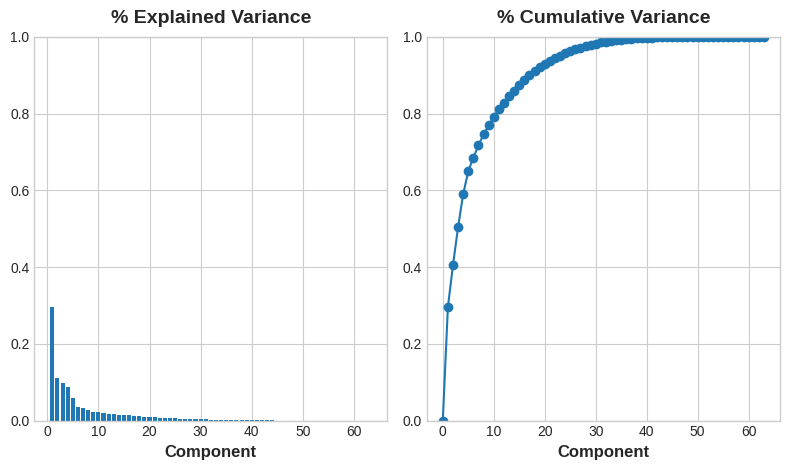

Accuracy: 63.02 %



In [49]:
###################
# PCA Experiments #
###################

import seaborn as sns

from sklearn.decomposition     import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection   import cross_val_score
from xgboost                   import XGBClassifier

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large", titleweight = "bold", titlesize = 14, titlepad = 10)


def apply_pca(X, standardize = True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis = 0)) / X.std(axis = 0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i + 1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns = component_names)
    # Create loadings
    loadings = pd.DataFrame(pca.components_.T,          # Transpose the matrix of loadings
                            columns = component_names,  # so that the columns are the principal components
                            index = X.columns)          # and the rows are the original features
    return pca, X_pca, loadings


def plot_variance(pca, width = 8, dpi = 100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel = "Component", title = "% Explained Variance", ylim = (0.0, 1.0))
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(xlabel = "Component", title = "% Cumulative Variance", ylim = (0.0, 1.0))
    # Set up figure
    fig.set(figwidth = 8, dpi = 100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features = discrete_features, random_state = 0)
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores


#print("Correlation with HT Win Target:\n")
#print(df_ld[features].corrwith(df_ld["Target HT Win"]))

bin_features = ["Participated Last Season HT", "Participated Last Season AT",
                "DC Have Met 1", "DC Have Met 2", "DC Have Met 1"]

non_bin_features = [f for f in features if f not in bin_features]

df_ld_features        = df_ld[non_bin_features]
df_ld_features_scaled = (df_ld_features - df_ld_features.mean(axis = 0)) / df_ld_features.std(axis = 0)

pca, df_ld_features_pca, loadings = apply_pca(df_ld_features_scaled)
#print(loadings)
plot_variance(pca)
plt.show()

mi_scores = make_mi_scores(df_ld_features_pca, df_ld["Target HT Win"])

#avg_mi = sum([mutual_info_classif(df_ld_features_pca[["PC1"]], df_ld["Target HT Win"]) for i in range(100)]) / 100
#print("Avg. MI score for PC1: %f" % avg_mi)

df_ld_wpca = pd.concat([df_ld, df_ld_features_pca["PC1"]], axis = "columns")

features_wpca = features.copy()
features_wpca.append("PC1")

df_train_wpca = df_ld_wpca[df_ld_wpca["Season Start Year"] <= 2013]
df_valid_wpca = df_ld_wpca[df_ld_wpca["Season Start Year"] >= 2014]

y_train_wpca = df_train_wpca["Target HT Win"]
y_valid_wpca = df_valid_wpca["Target HT Win"]

X_train_wpca = df_train_wpca[features_wpca]
X_valid_wpca = df_valid_wpca[features_wpca]

scaler_wpca = preprocessing.StandardScaler()

X_train_scaled_wpca = scaler_wpca.fit_transform(X_train_wpca)
X_valid_scaled_wpca = scaler_wpca.transform(X_valid_wpca)


from multiprocessing import cpu_count
from xgboost         import XGBClassifier

#xgb_wpca = XGBClassifier(n_estimators = 1_000, learning_rate = 0.02, n_jobs = cpu_count())
xgb_wpca = XGBClassifier(n_estimators = 1_500, n_jobs = cpu_count(), booster = "gbtree", learning_rate = 0.092,
                         min_split_loss = 0, max_depth = 3, min_child_weight = 1,
                         colsample_bytree = 0.91, colsample_bylevel = 0.88, colsample_bynode = 1,
                         scale_pos_weight = 1.00, tree_method = "exact")
 # These parameters should be tuned again though. They're just copied from the xgb-tuning-cell below.
xgb_wpca.set_params(early_stopping_rounds = 30)
xgb_wpca.fit(X_train_scaled_wpca, y_train_wpca, eval_set = [(X_valid_scaled_wpca, y_valid_wpca)], verbose = False)

pred_valid_wpca = xgb_wpca.predict(X_valid_scaled_wpca)

print("Accuracy: %2.2f %%\n" % (100 * accuracy_score(y_valid_wpca, pred_valid_wpca)))

In [99]:
########################################################
# SciKit-Learn Logistic Regression Classifier Approach #
########################################################

from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(max_iter = 5_000, solver = "lbfgs", penalty = "l2", C = 1.5)
reg.fit(X_train_scaled, y_train)

pred_valid = reg.predict(X_valid_scaled)

print("Accuracy: %2.2f %%\n" % (100 * accuracy_score(y_valid, pred_valid)))

#print(reg.coef_[0])

coefficients = []
for i in range(len(features)):
    coefficients.append([features[i], reg.coef_[0][i]])

ranked_coefficients = sorted(coefficients, key = lambda x: abs(x[1]), reverse = True)

print("Features ranked by absolute weight-coefficients:\n")
for i in range(len(ranked_coefficients)):
    print("%2.0f.) %-31s %9f" % (i + 1, ranked_coefficients[i][0] + ":", ranked_coefficients[i][1]))

Accuracy: 62.96 %

Features ranked by absolute weight-coefficients:

 1.) Fin Points Diff Pow 3 Weighted: -0.612124
 2.) Fin Points Diff Pow 5:          -0.599794
 3.) Weighted Points Diff Pow 5 Sum:  0.576363
 4.) Weighted Points Diff Pow 2 Sum:  0.556147
 5.) Weighted Points Diff Pow 3 Sum: -0.554401
 6.) Fin Points Diff Pow 2 Weighted:  0.431450
 7.) Cur Points Diff Pow 5 Weighted:  0.417910
 8.) Fin Points Diff Pow 5 Weighted:  0.414794
 9.) Cur Points Diff Pow 2 Weighted:  0.397712
10.) Match Day:                      -0.388363
11.) Cur Points Diff Pow 4:          -0.375563
12.) Fin Points Diff Pow 4:           0.361499
13.) Cur Points Diff Pow 1 Weighted: -0.332560
14.) Cur Points Diff Pow 4 Weighted: -0.318646
15.) Cur AT Goals Conceded:           0.305293
16.) Cur HT Points:                   0.284822
17.) Weighted Points Diff Pow 4 Sum: -0.284671
18.) Cur AT Goals Shot:              -0.275693
19.) Cur Points Diff Pow 2:           0.269917
20.) Cur Points Diff Pow 3 Weighted: -

In [51]:
##################################################
# SciKit-Learn Decision Tree Classifier Approach #
##################################################

from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion = "gini", splitter = "best", min_samples_leaf = 1378)   # Optimum
dtc.fit(X_train_scaled, y_train)

pred_valid = dtc.predict(X_valid_scaled)
print("Accuracy: %2.2f %%\n" % (100 * accuracy_score(y_valid, pred_valid)))

#best_avg_acc = 0
#arg_max      = 0
#for min_samples_leaf in range(1, floor(len(X_train_scaled) / 2) + 1):
#    n = 200
#    avg_accuracy = 0
#    for k in range(n):
#        dtc = DecisionTreeClassifier(criterion = "entropy", splitter = "best", min_samples_leaf = min_samples_leaf)
#        dtc.fit(X_train_scaled, y_train)
#        pred_valid = dtc.predict(X_valid_scaled)
#        avg_accuracy += accuracy_score(y_valid, pred_valid)
#    avg_accuracy /= n
#    print("Avg. accuracy at min_samples_leaf = %d: %2.2f %%" % (min_samples_leaf, 100 * avg_accuracy))
#    if avg_accuracy > best_avg_acc:
#        best_avg_acc = avg_accuracy
#        arg_max = min_samples_leaf
#    print("--> In current range up to now: best_avg_acc = %f at arg_max = %d\n" % (best_avg_acc, arg_max))

Accuracy: 63.54 %



In [98]:
##################################################
# SciKit-Learn Random Forest Classifier Approach #
##################################################

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 1_800, min_samples_leaf = 707, bootstrap = True, random_state = 0)
 # Best parameters found
rfc.fit(X_train_scaled, y_train)

pred_valid = rfc.predict(X_valid_scaled)

print("Accuracy: %2.2f %%\n" % (100 * accuracy_score(y_valid, pred_valid)))

#n            = 5   # 200
#best_avg_acc = 0
#arg_max      = 0
#for i in range(1, 2000 + 1):
##for i in range(149, 404 + 1, ceil((404 - 149) / 10)):
##for i in range(245, 279 + 1):
#    #min_samples_leaf = ceil(exp(i / 2))
#    min_samples_leaf = i
#    avg_accuracy     = 0
#    for k in range(n):
#        rfc = RandomForestClassifier(n_estimators = 300, min_samples_leaf = min_samples_leaf, bootstrap = True)
#        rfc.fit(X_train_scaled, y_train)
#        pred_valid = rfc.predict(X_valid_scaled)
#        avg_accuracy += accuracy_score(y_valid, pred_valid)
#    avg_accuracy /= n
#    print("Avg. accuracy at min_samples_leaf = %d: %2.2f %%" % (min_samples_leaf, 100 * avg_accuracy))
#    if avg_accuracy > best_avg_acc:
#        best_avg_acc = avg_accuracy
#        arg_max      = min_samples_leaf
#    print("--> In current range up to now: best_avg_acc = %f at arg_max = %d\n" % (best_avg_acc, arg_max))

Accuracy: 63.02 %



In [95]:
###################################################
# SciKit-Learn Support Vector Classifier Approach #
###################################################

from sklearn.svm import SVC
# best_acc = 63.44 % found at at C =   9.060, gamma = 0.00023, kernel = rbf
svc = SVC(C = 9.060, gamma = 0.00023, kernel = "rbf")
svc.fit(X_train_scaled, y_train)

pred_valid = svc.predict(X_valid_scaled)

print("Accuracy: %2.2f %%\n" % (100 * accuracy_score(y_valid, pred_valid)))

#best_acc       = 0
#arg_max_C      = 0
#arg_max_gamma  = 0
#arg_max_kernel = 0
#for kernel in ["rbf"]:
#            # ["rbf", "poly", "sigmoid"]:
#    for C in [0.01 * i for i in range(800, 1000 + 1)]:
#           # [0.1, 1, 10, 100]
#        for gamma in [0.00023]:
#                   # [0.00001 * i for i in range(10, 40 + 1)]:
#                   # [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.0010]:
#                   # [1, 0.1, 0.01, 0.001]:
#            svc = SVC(C = C, gamma = gamma, kernel = kernel)
#            svc.fit(X_train_scaled, y_train)
#            pred_valid = svc.predict(X_valid_scaled)
#            acc = accuracy_score(y_valid, pred_valid)
#            print("Accuracy: %2.2f %% at C = %7.3f, gamma = %7.5f, kernel = %s" \
#                  % (100 * acc, C, gamma, kernel))
#            if acc > best_acc:
#                best_acc       = acc
#                arg_max_C      = C
#                arg_max_gamma  = gamma
#                arg_max_kernel = kernel
#print("best_acc = %2.2f %% found at at C = %7.3f, gamma = %7.5f, kernel = %s" \
#                  % (100 * best_acc, arg_max_C, arg_max_gamma, arg_max_kernel))

Accuracy: 63.44 %



In [120]:
#############################################
# SciKit-Learn K Nearest Neighbors Approach #
#############################################

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 12, p = 2)   # Best parameters found
knn.fit(X_train_scaled, y_train)

pred_valid = knn.predict(X_valid_scaled)

print("Accuracy: %2.2f %%\n" % (100 * accuracy_score(y_valid, pred_valid)))

#best_acc            = 0
#arg_max_n_neighbors = 0
#arg_max_p           = 0
#for n_neighbors in range(1, 20):
#    for p in [1, 1.5, 2, 2.5, 3]:
#        knn = KNeighborsClassifier(n_neighbors = n_neighbors, p = p)
#        knn.fit(X_train_scaled, y_train)
#        pred_valid = knn.predict(X_valid_scaled)
#        acc = accuracy_score(y_valid, pred_valid)
#        print("Accuracy: %2.2f %% at n_neighbors = %2d, p = %f" % (100 * acc, n_neighbors, p))
#        if acc > best_acc:
#            best_acc            = acc
#            arg_max_n_neighbors = n_neighbors
#            arg_max_p           = p
#print("\nbest_acc = %2.2f %% found at n_neighbors = %2d, p = %f" % (100 * best_acc, arg_max_n_neighbors, arg_max_p))

Accuracy: 60.48 %



In [121]:
#########################################################
# SciKit-Learn Gaussian Naive Bayes Classifier Approach #
#########################################################

# Since the computed features are clearly not independent,
# this approach should not be expected to create sensible results.
# The best value for the parameter var_smoothing being 27
# instead of a tiny fraction doesn't make sense at all.
# It was tested just out of curiosity after accidentally testing
# natural numbers and suddenly getting better accuracies.

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB(var_smoothing = 27)
gnb.fit(X_train_scaled, y_train)

pred_valid = gnb.predict(X_valid_scaled)

print("Accuracy: %2.2f %%\n" % (100 * accuracy_score(y_valid, pred_valid)))


#best_acc = 0
#arg_max  = 0
#for var_smoothing in [10**(-i) for i in range(1, 20 + 1)] + [i for i in range(100 + 1)]:
#    gnb = GaussianNB(var_smoothing = var_smoothing)
#    gnb.fit(X_train_scaled, y_train)
#    pred_valid = gnb.predict(X_valid_scaled)
#    acc = accuracy_score(y_valid, pred_valid)
#    print("Accuracy: %2.2f %% at var_smoothing = %f" % (100 * acc, var_smoothing))
#    if acc > best_acc:
#        best_acc = acc
#        arg_max  = var_smoothing
#print("\nbest_acc = %2.2f %% found at var_smoothing = %f" % (100 * best_acc, arg_max))

Accuracy: 63.49 %



In [47]:
####################
# XGBoost Approach #
####################

from multiprocessing import cpu_count
from xgboost         import XGBClassifier

xgb = XGBClassifier(n_estimators = 1_500, n_jobs = cpu_count(), booster = "gbtree", learning_rate = 0.092,
                    min_split_loss = 0, max_depth = 3, min_child_weight = 1,
                    colsample_bytree = 0.91, colsample_bylevel = 0.88, colsample_bynode = 1,
                    scale_pos_weight = 1.00, tree_method = "exact") # Best parameters found
                                                                    # Accuracy: 63.60 %
xgb.set_params(early_stopping_rounds = 30)
xgb.fit(X_train_scaled, y_train, eval_set = [(X_valid_scaled, y_valid)], verbose = False)

pred_valid = xgb.predict(X_valid_scaled)

print("Accuracy: %2.2f %%\n" % (100 * accuracy_score(y_valid, pred_valid)))


best_acc = 0
arg_max  = 0
# arg_max_colsample_bylevel = 0
# arg_max_colsample_bynode  = 0
#for learning_rate in [0.01 * i for i in range(1, 20 + 1)]:
#for learning_rate in [0.001 * i for i in range(100, 350 + 1)]:
#for gamma in [10**(-i) for i in range(0, 10 + 1)]:
#for colsample_bytree in [0.01 * i for i in range(50, 100 + 1)]:
#    for colsample_bylevel in [0.01 * i for i in range(50, 100 + 1)]:
#        for colsample_bynode in [0.01 * i for i in range(50, 100 + 1)]:
for scale_pos_weight in [0.01 * i for i in range(80, 120 + 1)]:
        xgb = XGBClassifier(n_estimators = 1_500, n_jobs = cpu_count(), booster = "gbtree", learning_rate = 0.092,
                            min_split_loss = 0, max_depth = 3, min_child_weight = 1,
                            colsample_bytree = 0.91, colsample_bylevel = 0.88, colsample_bynode = 1.00,
                            scale_pos_weight = scale_pos_weight)
        xgb.set_params(early_stopping_rounds = 30)
        xgb.fit(X_train_scaled, y_train, eval_set = [(X_valid_scaled, y_valid)], verbose = False)
        pred_valid = xgb.predict(X_valid_scaled)
        acc = accuracy_score(y_valid, pred_valid)
        print("Accuracy: %2.2f %% at scale_pos_weight = %f" % (100 * acc, scale_pos_weight))
        if acc > best_acc:
            best_acc = acc
            arg_max  = scale_pos_weight
            #arg_max_colsample_bylevel = colsample_bylevel
            #arg_max_colsample_bynode  = colsample_bynode
print("\nbest_acc = %2.2f %% found at scale_pos_weight = %f" % (100 * best_acc, arg_max))

Accuracy: 63.60 %

Accuracy: 63.02 % at scale_pos_weight = 0.800000
Accuracy: 63.02 % at scale_pos_weight = 0.810000
Accuracy: 62.86 % at scale_pos_weight = 0.820000
Accuracy: 63.23 % at scale_pos_weight = 0.830000
Accuracy: 62.75 % at scale_pos_weight = 0.840000
Accuracy: 62.96 % at scale_pos_weight = 0.850000
Accuracy: 63.17 % at scale_pos_weight = 0.860000
Accuracy: 63.12 % at scale_pos_weight = 0.870000
Accuracy: 63.12 % at scale_pos_weight = 0.880000
Accuracy: 63.49 % at scale_pos_weight = 0.890000
Accuracy: 62.86 % at scale_pos_weight = 0.900000
Accuracy: 62.70 % at scale_pos_weight = 0.910000
Accuracy: 62.38 % at scale_pos_weight = 0.920000
Accuracy: 62.75 % at scale_pos_weight = 0.930000
Accuracy: 62.96 % at scale_pos_weight = 0.940000
Accuracy: 62.75 % at scale_pos_weight = 0.950000
Accuracy: 62.49 % at scale_pos_weight = 0.960000
Accuracy: 63.17 % at scale_pos_weight = 0.970000
Accuracy: 63.12 % at scale_pos_weight = 0.980000
Accuracy: 62.96 % at scale_pos_weight = 0.990000
A

Epoch 1/1000
36/36 [==============================] - 1s 9ms/step - loss: 0.7259 - binary_accuracy: 0.5136 - val_loss: 0.6907 - val_binary_accuracy: 0.5291
Epoch 2/1000
36/36 [==============================] - 0s 6ms/step - loss: 0.7038 - binary_accuracy: 0.5331 - val_loss: 0.6733 - val_binary_accuracy: 0.5825
Epoch 3/1000
36/36 [==============================] - 0s 5ms/step - loss: 0.6871 - binary_accuracy: 0.5540 - val_loss: 0.6676 - val_binary_accuracy: 0.5815
Epoch 4/1000
36/36 [==============================] - 0s 5ms/step - loss: 0.6885 - binary_accuracy: 0.5624 - val_loss: 0.6637 - val_binary_accuracy: 0.5889
Epoch 5/1000
36/36 [==============================] - 0s 5ms/step - loss: 0.6829 - binary_accuracy: 0.5564 - val_loss: 0.6608 - val_binary_accuracy: 0.5931
Epoch 6/1000
36/36 [==============================] - 0s 5ms/step - loss: 0.6810 - binary_accuracy: 0.5604 - val_loss: 0.6594 - val_binary_accuracy: 0.5905
Epoch 7/1000
36/36 [==============================] - 0s 5ms/ste

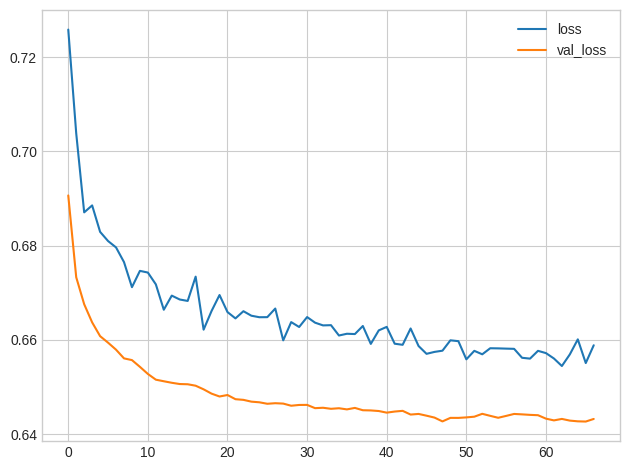

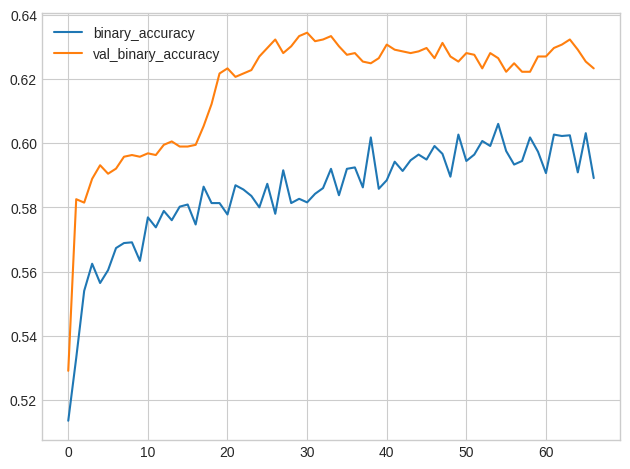

60/60 [==============================] - 0s 2ms/step

Minimum loss_train:     0.6544530391693115
Minimum loss_valid:     0.642666757106781
Maximum bin_acc_train:  0.6060000061988831
Maximum bin_acc_valid:  0.6343915462493896

Accuracy: 63.44 %



In [31]:
#############################################
# Keras - TensorFlow Deep Learning Approach #
#############################################

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from   tensorflow                 import keras
from   tensorflow.keras           import layers
from   tensorflow.keras.callbacks import EarlyStopping

# Create model

#model = keras.Sequential([layers.BatchNormalization(),
#                          layers.Dense( 1, activation = "sigmoid", input_shape = [len(features)])
#                         ])

model = keras.Sequential([layers.BatchNormalization(input_shape = [len(features)]),
                          layers.Dense( 8, activation = "relu"),
                          layers.Dropout(0.2),
                          layers.BatchNormalization(),
                          layers.Dense( 4, activation = "relu"),
                          layers.Dropout(0.2),
                          layers.BatchNormalization(),
                          layers.Dense( 1, activation = "sigmoid")
                         ])

#model = keras.Sequential([layers.BatchNormalization(),
#                          layers.Dense(64, activation = "relu", input_shape = [len(features)]),
#                          layers.Dropout(0.2),
#                          layers.BatchNormalization(),
#                          layers.Dense(32, activation = "relu"),
#                          layers.Dropout(0.2),
#                          layers.BatchNormalization(),
#                          layers.Dense( 8, activation = "relu"),
#                          layers.Dropout(0.2),
#                          layers.BatchNormalization(),
#                          layers.Dense( 4, activation = "relu"),
#                          layers.Dropout(0.2),
#                          layers.BatchNormalization(),
#                          layers.Dense( 1, activation = "sigmoid")
#                         ])

#model = keras.Sequential([layers.BatchNormalization(),
#                          layers.Dense(1024, activation = "relu", input_shape = [len(features)]),
#                          layers.Dropout(0.2),
#                          layers.BatchNormalization(),
#                          layers.Dense( 256, activation = "relu"),
#                          layers.Dropout(0.2),
#                          layers.BatchNormalization(),
#                          layers.Dense(  64, activation = "relu"),
#                          layers.Dropout(0.2),
#                          layers.BatchNormalization(),
#                          layers.Dense(  16, activation = "relu"),
#                          layers.Dropout(0.2),
#                          layers.BatchNormalization(),
#                          layers.Dense(   4, activation = "relu"),
#                          layers.Dropout(0.2),
#                          layers.BatchNormalization(),
#                          layers.Dense(   1, activation = "sigmoid")
#                         ])

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = "binary_accuracy")

# Fit model

early_stopping = EarlyStopping(min_delta = 0.001, patience = 20, restore_best_weights = True)

history = model.fit(X_train_scaled, y_train,
                    validation_data = (X_valid_scaled, y_valid),
                    batch_size      = 128,
                    epochs          = 1_000,
                    callbacks       = [early_stopping],
                    verbose         = 1)


##############
# Validation #
##############

# Setup plotting

plt.style.use("seaborn-whitegrid")

# Set Matplotlib defaults

plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large", titleweight = "bold", titlesize = 18, titlepad = 10)

# Show the learning curves

history_df = pd.DataFrame(history.history)
history_df.loc[:, ["loss", "val_loss"]].plot()
history_df.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot()
plt.show()

# Metrics

pred_valid = model.predict(X_valid_scaled)
mse        = mean_squared_error(y_valid, pred_valid)
#t_c_acc    = three_classes_accuracy(y_valid, pred_valid)

print()
print("Minimum loss_train:     " + str(history_df["loss"].min()))
print("Minimum loss_valid:     " + str(history_df["val_loss"].min()))
#print("MSE:                    " + str(mse))
#print("3 Classes Accuracy:     " + str(t_c_acc))
print("Maximum bin_acc_train:  " + str(history_df["binary_accuracy"].max()))
print("Maximum bin_acc_valid:  " + str(history_df["val_binary_accuracy"].max()))

print("\nAccuracy: %2.2f %%\n" % (100 * history_df["val_binary_accuracy"].max()))

In [17]:
###############################################
# Keras - TensorFlow Decision Forest Approach #
###############################################

# This is adapted from the following source:
#
# https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
#
# Upgrade: The usage of the gradient boosted tree is adapted from:
#
# https://www.kaggle.com/code/carlmcbrideellis/classification-using-tensorflow-decision-forests/notebook

import math
import os
import numpy                       as np
import pandas                      as pd
import tensorflow                  as tf
import tensorflow_decision_forests as tfdf

print("Found TensorFlow Decision Forests version '" + tfdf.__version__ + "'.")

df_tfdf_train = pd.concat([X_train, y_train], axis = 1)
df_tfdf_valid = pd.concat([X_valid, y_valid], axis = 1)

df_tfdf_train.rename(columns = {"Target HT Win" : "Target"}, inplace = True)
df_tfdf_valid.rename(columns = {"Target HT Win" : "Target"}, inplace = True)

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_tfdf_train, label = "Target")
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_tfdf_valid, label = "Target")

# Specify the model
#model_1 = tfdf.keras.RandomForestModel(verbose = 2)
model_1 = tfdf.keras.GradientBoostedTreesModel(num_trees = 1500)

# Train the model
model_1.fit( x = train_ds)

# Evaluate the model
model_1.compile(metrics = ["accuracy"])
evaluation = model_1.evaluate(valid_ds, return_dict = True)

print()
#for name, value in evaluation.items():
#    print("%-9s %.4f" % (name + ":", value))

print("Accuracy: %2.2f %%\n" % (100 * evaluation.get("accuracy")))

#model_1.summary()

Found TensorFlow Decision Forests version '0.2.7'.


/home/daniel/.local/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
/home/daniel/.local/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


Use /tmp/tmpi8tu9at0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.378109. Found 4500 examples.
Training model...
Model trained in 0:00:00.769083
Compiling model...


[INFO kernel.cc:1176] Loading model from path /tmp/tmpi8tu9at0/model/ with prefix 2088f537c96141a8
[INFO abstract_model.cc:1248] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1022] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
2/2 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 0.6222

Accuracy: 62.22 %



In [18]:
#########################################################
# Useful Conversion-Functions for Classification Issues #
#########################################################


def binary_classified_value(value):
    if value >= 0.5:
        return 1
    else:
        return 0


def three_classes_classified_value(value):   # The following indentations are supposed to simplify arithmetic understanding.
    if   value <= 1 / 3:
        return 0
    elif          1 / 3 <  value and value < 2 / 3:
        return 0.5
    elif                                     2 / 3 <= value:
        return 1


def three_classes_accuracy(y_valid, pred_valid):
    
    n = len(y_valid)
    
    success_count = 0
    
    for i in range(n):
        if y_valid.iloc[i] == three_classes_classified_value(pred_valid[i]):
            success_count += 1
    
    return success_count / n

In [19]:
##################################################
# Useful Plots to Compare Match Day and Accuracy #
##################################################


def plot_match_days_and_mse(X_valid, y_valid, pred_valid, match_days_per_season):
    
    match_days = list(range(1, match_days_per_season + 1))
    
    mses        = [0 for i in range(match_days_per_season + 1)]
    frequencies = [0 for i in range(match_days_per_season + 1)]
    
    for i in range(len(X_valid)):
        match_day               = X_valid.iloc[i]["Match Day"]
        mses[match_day]        += (y_valid.iloc[i] - pred_valid[i])**2
        frequencies[match_day] += 1
    
    for match_day in range(1, match_days_per_season + 1):
        if frequencies[match_day] > 0:
            mses[match_day] = mses[match_day] / frequencies[match_day]
    
    del mses[0]
    
    plt.scatter(match_days, mses)
    plt.xlim([0.5, 34.5])
    plt.ylim([0.0,  1.0])
    plt.show()


def plot_match_days_and_binary_accuracy(X_valid, y_valid, pred_valid, match_days_per_season):
    
    match_days = list(range(1, match_days_per_season + 1))
    
    accuracies  = [0 for i in range(match_days_per_season + 1)]
    frequencies = [0 for i in range(match_days_per_season + 1)]
    
    for i in range(len(X_valid)):
        match_day               = X_valid.iloc[i]["Match Day"]
        if binary_classified_value(pred_valid[i]) == y_valid.iloc[i]:
            accuracies[match_day]  += 1
        frequencies[match_day] += 1
    
    for match_day in range(1, match_days_per_season + 1):
        if frequencies[match_day] > 0:
            accuracies[match_day] = accuracies[match_day] / frequencies[match_day]
    
    del accuracies[0]
    
    plt.scatter(match_days, accuracies)
    plt.xlim([0.5, 34.5])
    plt.ylim([0.0,  1.0])
    plt.show()

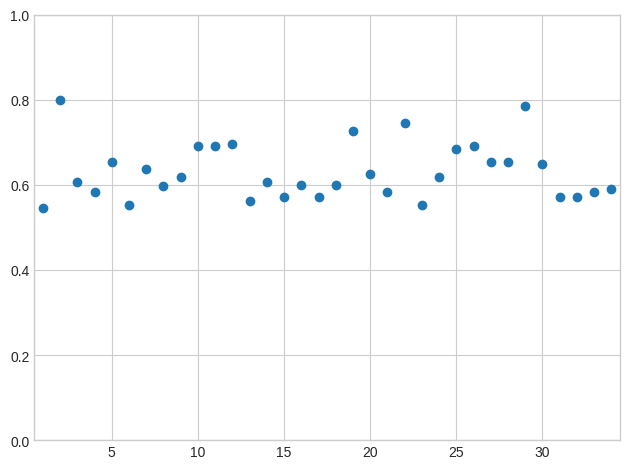

In [20]:
teams_per_season       = 18
matches_per_match_day  = teams_per_season // 2
match_days_per_season  = (teams_per_season - 1) * 2

#plot_match_days_and_mse(X_valid, y_valid, pred_valid, match_days_per_season)
plot_match_days_and_binary_accuracy(X_valid, y_valid, pred_valid, match_days_per_season)